# Understanding the IMDB Reviews Data Set

Instructions
* You will need to make a new virtual enviroment so that the libraries we are going to use will work
    * Steps to create a virtual enviroment:
        * Go to the project directory and run this command:
            * python -m venv IMDB_ven
        * Then on MacOS, type this command:
            * source IMDB_ven/bin/activate
        * On Windows, type these commands:
            * Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass
            * IMDB_ven\Scripts\activate
        * Now we are in the virtual enviroment
* Then download the libraries using the requirements.txt file, we will continue to add to this file if we need more libraries in our project
    * Run this command in your terminal to download the libraries:
        * pip install -r requirements.txt
* Now lets open the aclImdb_v1.tar.gz file
    * We can use the tar command to open up the file:
        * tar -xzvf aclImdb_v1.tar.gz
            * -x: Extracts the files
            * -z: Unzips the gzipped file
            * -v: Verbosely lists the files being extracted
            * -f: Specifies the file name
* Word of caution:
    * After unzipping the file please do not push the acllmdb file to the github repository since it is very large, that means typing 'git add .' will add this file to the github repository (by basically adding everything) so avoid using the '.'
    * Instead just add the files you would like to push by doing 'git add <name_of_file_you_want_to_push>'
    * Do not add the aclImdb_v1.tar.gz to github, just have this file in your local enviroment

In [2]:
# Checking if CUDA is enabled

import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
    
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2070 SUPER


In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load a fine-tuned model for sentiment analysis
model_name = 'textattack/bert-base-uncased-SST-2'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Example text
text1 = 'This is a good movie. I like it'
text2 = 'This is a bad movie. I hate it'

# Tokenize and get predictions
tokens1 = tokenizer(text1, return_tensors='pt', padding=True, truncation=True)
tokens2 = tokenizer(text2, return_tensors='pt', padding=True, truncation=True)

# Get model predictions
result1 = model(**tokens1)
result2 = model(**tokens2)

# Extract the predicted sentiment class (0 = negative, 1 = positive)
sentiment1 = int(torch.argmax(result1.logits))
sentiment2 = int(torch.argmax(result2.logits))

# Output the sentiment labels
sentiment_map = {0: 'Negative', 1: 'Positive'}

print(f'Text 1: {sentiment_map[sentiment1]} \nText 2: {sentiment_map[sentiment2]}')

c:\Developer\cs178-group-project\IMDB_ven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text 1: Positive 
Text 2: Negative


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud  
from sklearn.model_selection import train_test_split

# these libraries are used for the text cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#these libraries are building the model
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer,  BertModel, BertForSequenceClassification
from tqdm.auto import tqdm


# seed for reproducibility
seed = 1111

In [5]:
# have a seperate helper function to load reviews from a folder
def load_reviews(folder_path, label):
    reviews = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            reviews.append(file.read())
    return pd.DataFrame({"review": reviews, "label": label})

In [6]:
# here we will store the base path to the dataset, then load the positive and negative reviews from the training data set to a dataframe
base_path = "aclImdb"

# since this is a classification problem, we will give pos reviews a 1 and neg reviews a 0
train_pos = load_reviews(os.path.join(base_path, "train/pos"), label=1)
train_neg = load_reviews(os.path.join(base_path, "train/neg"), label=0)
train_data_sorted = pd.concat([train_pos, train_neg]).reset_index(drop=True)
train_data = train_data_sorted.sample(frac=1, random_state=seed).reset_index(drop=True)

test_pos = load_reviews('./aclImdb/test/pos', label=1)
test_neg = load_reviews('./aclImdb/test/neg', label=0)
test_data_sorted = pd.concat([test_pos, test_neg]).reset_index(drop=True)
test_data = test_data_sorted.sample(frac=1, random_state=seed).reset_index(drop=True)

In [7]:
#delete later, smaller data for faster testing

# train_data = train_data.sample(n=5000, random_state=seed)
# test_data = test_data.sample(n=5000, random_state=seed)

In [8]:
# show the data to get a rough idea of what we have
print("Number of reviews:", len(train_data))
display(train_data)
train_data.info()

Number of reviews: 25000


,review,label
0,Astounding.....This may have been A poor attem...,1
1,This waste of time is a completely unnecessary...,0
2,I probably give this more credit than it deser...,0
3,"""Enter the Fat Dragon"" is one of the funniest ...",1
4,"Take your basic Frankenstein flick, inject som...",0
...,...,...
24995,The potential was there. I saw Creep and thoug...,0
24996,"I used to write comments at IMDb, but I don't ...",1
24997,Let's start this review out on a positive note...,1
24998,"The movie was a suspenseful, and somewhat dark...",1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [9]:
print("Number of reviews (test):", len(train_data))
display(test_data)
train_data.info()

Number of reviews (test): 25000


,review,label
0,"""Empire Strikes Back"" director Irvin Kershner'...",1
1,What on earth? Like watching an episode of Nei...,0
2,I was one of the many fools who were sapped ou...,0
3,**SPOILERS** Shocking yet true story of the ho...,1
4,Some movies are just unlucky. These are the ...,0
...,...,...
24995,There is not one character on this sitcom with...,0
24996,So after years and years I finally track this ...,1
24997,I have read the last comment made on this film...,1
24998,What a film. Quite possibly the best I've ever...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [10]:
# we want to check the distribution of the data so that we can identify any imbalanced in the data
print("Label distribution:\n", train_data["label"].value_counts())

Label distribution:
 label
1    12500
0    12500
Name: count, dtype: int64


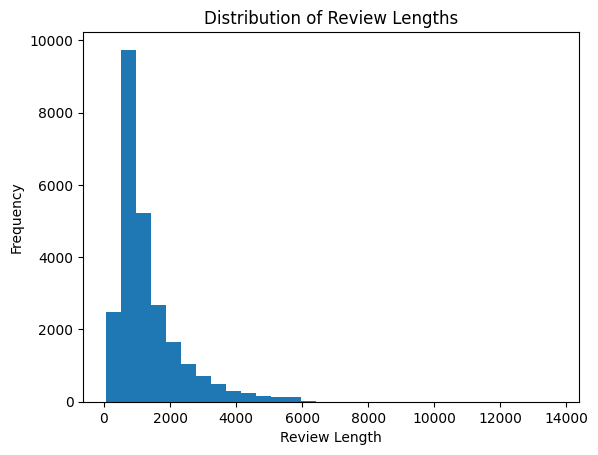

In [11]:
# looks like the data is evenly balanced, so now we want to see how long these reviews are
train_data["review_length"] = train_data["review"].apply(len) # creating a new column that stores the length of the data
plt.hist(train_data["review_length"], bins=30)
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

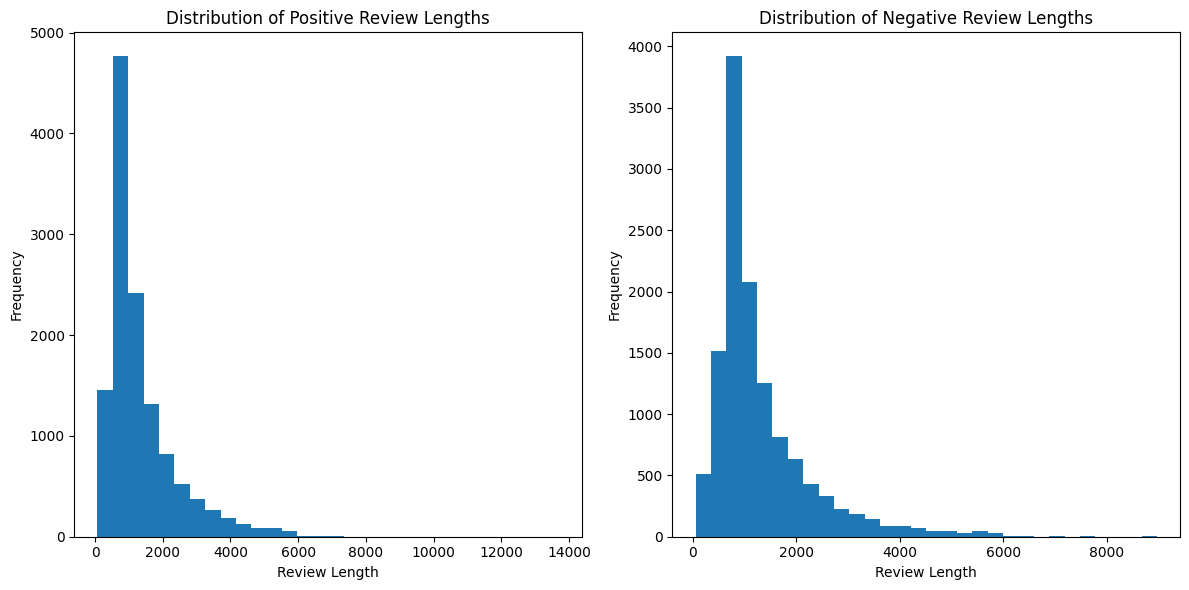

In [12]:
# we can try to see the length of reviews for both the negative and positive reviews as well
pos_reviews = train_data[train_data["label"] == 1]
neg_reviews = train_data[train_data["label"] == 0]

plt.figure(figsize=(12, 6))

# positive reviews
plt.subplot(1, 2, 1) # this graph will be stored in the first row first column
plt.hist(pos_reviews["review_length"], bins=30)
plt.title("Distribution of Positive Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")

# negative reviews
plt.subplot(1, 2, 2) # this graph will be stored in the first row second column
plt.hist(neg_reviews["review_length"], bins=30)
plt.title("Distribution of Negative Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [13]:
# it looks like the negative reviews have slightly longer reviews compared to the positive reviews, but at a galnce it does not look like much of a difference
# now I want to display the word frequency of the review data by using the word cloud, but first I will clean the text data and save it as a column to the data frame

# we need to run this bit of code for the cleaning to work, but you only need to run it once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\safia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\safia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\safia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# helper function clean text function to convert text to lowercase, remove special characters
# (punctuation, numbers, etc.), remove stop words, tokenize, and apply lemmatization

def clean_text(text):
  text = text.lower()

  text = re.sub(r'[^a-zA-Z\s]', '', text)

  tokens = word_tokenize(text)

  stop_words = set(stopwords.words("english"))
  tokens = [word for word in tokens if word not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  cleaned_text = ' '.join(tokens)

  return cleaned_text

In [15]:
# only need to run the cell once
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\safia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\safia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\safia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\safia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
train_data["cleaned_review"] = train_data["review"].apply(clean_text) # create a new column in our data frame that has the cleaned text so we can use it later
# we wont be using this cleaned text in the BERT model since it would perform poorly on pre cleaned data, so we will just use this for analysis and such

In [17]:
train_data.head()

,review,label,review_length,cleaned_review
0,Astounding.....This may have been A poor attem...,1,867,astoundingthis may poor attempt remaking alrea...
1,This waste of time is a completely unnecessary...,0,528,waste time completely unnecessary remake great...
2,I probably give this more credit than it deser...,0,3231,probably give credit deserves halloween knotts...
3,"""Enter the Fat Dragon"" is one of the funniest ...",1,1113,enter fat dragon one funniest martial art movi...
4,"Take your basic Frankenstein flick, inject som...",0,1190,take basic frankenstein flick inject reanimato...


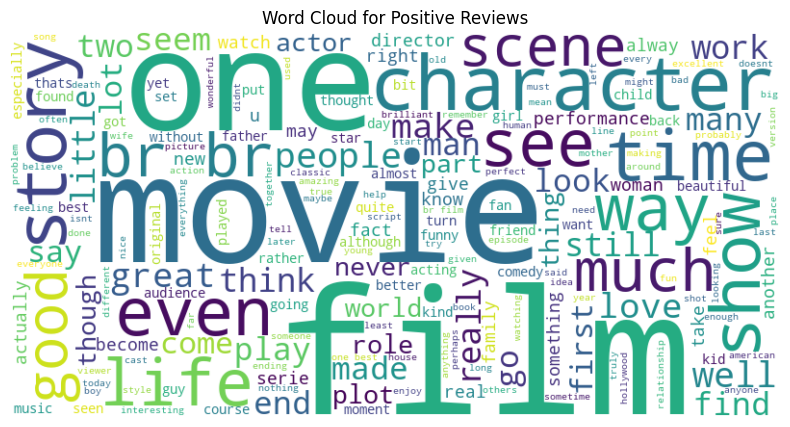

In [18]:
# lets take a look at the word cloud for the positive reviews then the neagtive reviews
pos_text = ' '.join(train_data[train_data["label"] == 1]["cleaned_review"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(pos_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

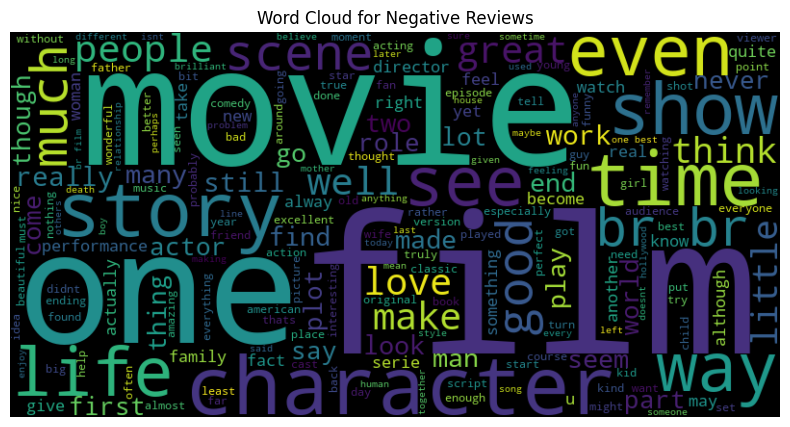

In [19]:
# then the negatvie reviews
neg_text = ' '.join(train_data[train_data["label"] == 0]["cleaned_review"])
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(pos_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [20]:
# take a look at the changes we made to the datafram again here
display(train_data)

,review,label,review_length,cleaned_review
0,Astounding.....This may have been A poor attem...,1,867,astoundingthis may poor attempt remaking alrea...
1,This waste of time is a completely unnecessary...,0,528,waste time completely unnecessary remake great...
2,I probably give this more credit than it deser...,0,3231,probably give credit deserves halloween knotts...
3,"""Enter the Fat Dragon"" is one of the funniest ...",1,1113,enter fat dragon one funniest martial art movi...
4,"Take your basic Frankenstein flick, inject som...",0,1190,take basic frankenstein flick inject reanimato...
...,...,...,...,...
24995,The potential was there. I saw Creep and thoug...,0,810,potential saw creep thought oooh getting inter...
24996,"I used to write comments at IMDb, but I don't ...",1,1179,used write comment imdb dont anymore happens i...
24997,Let's start this review out on a positive note...,1,1931,let start review positive note glad didnt deci...
24998,"The movie was a suspenseful, and somewhat dark...",1,291,movie suspenseful somewhat dark look severe re...


In [21]:
# Work with cleaned data
'''
X_train = list(train_data['cleaned_review'])
X_test = list(test_data['cleaned_review'])
Y_train = list(train_data['label'])
Y_test = list(test_data['label'])

#splitting the train set into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=seed)
'''

"\nX_train = list(train_data['cleaned_review'])\nX_test = list(test_data['cleaned_review'])\nY_train = list(train_data['label'])\nY_test = list(test_data['label'])\n\n#splitting the train set into train and validation\nX_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=seed)\n"

In [22]:
X_train = list(train_data['review'])
X_test = list(test_data['review'])
Y_train = list(train_data['label'])
Y_test = list(test_data['label'])


#splitting the train set into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=seed)

# Print the number of examples in each split
print(f"Number of training examples: {len(X_train)}")
print(f"Number of validation examples: {len(X_val)}")
print(f"Number of testing examples: {len(X_test)}")
print(f"Number of training labels: {len(Y_train)}")
print(f"Number of validation labels: {len(Y_val)}")
print(f"Number of testing labels: {len(Y_test)}")


Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000
Number of training labels: 20000
Number of validation labels: 5000
Number of testing labels: 25000


In [23]:
# Construct a BERT tokenizer, reutrns a list of input IDs with the appropriate special tokens.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [24]:
# Tokenizing function
def tokenize_data(texts, tokenizer, max_len=512):
    return tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",  # Pads to max_len
        truncation=True,      # Truncates to max_len
        return_tensors="pt"   # Returns PyTorch tensors
    )

# Tokenize datasets
train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)


In [25]:
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = IMDBDataset(train_encodings, Y_train)
val_dataset = IMDBDataset(val_encodings, Y_val)
test_dataset = IMDBDataset(test_encodings, Y_test)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Scheduler (optional)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(softmax(logits, dim=1), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [28]:
def evaluate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(softmax(logits, dim=1), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total


In [29]:
epochs = 3
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = evaluate_epoch(model, val_loader, device)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1/3
Train Loss: 0.2630 | Train Accuracy: 0.8923
Val Loss: 0.2562 | Val Accuracy: 0.8962
Epoch 2/3
Train Loss: 0.1366 | Train Accuracy: 0.9509
Val Loss: 0.2523 | Val Accuracy: 0.9020
Epoch 3/3
Train Loss: 0.0841 | Train Accuracy: 0.9713
Val Loss: 0.2480 | Val Accuracy: 0.9130


In [30]:
test_loss, test_acc = evaluate_epoch(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Test Loss: 0.2353 | Test Accuracy: 0.9158


In [31]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels_list = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)  # to keep track of labels

            # forward pass
            outputs = model.bert(input_ids, attention_mask=attention_mask)

            # CLS token embedding (the first token) (access the hidden states because they contain the embeddings that capture the meaning of the text)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_size)

            embeddings.append(cls_embeddings.cpu())  # store embeddings on the CPU since it is bigger
            labels_list.append(labels.cpu())  # store labels

    embeddings = torch.cat(embeddings, dim=0)  # combine all batches
    labels_list = torch.cat(labels_list, dim=0)  # combine all labels
    return embeddings, labels_list

In [32]:
# extract embeddings for the training, validation, and test set
train_embeddings, train_labels = extract_embeddings(model, train_loader, device)
val_embeddings, val_labels = extract_embeddings(model, val_loader, device)
test_embeddings, test_labels = extract_embeddings(model, test_loader, device)

In [33]:
all_embeddings = torch.cat([train_embeddings, val_embeddings, test_embeddings], dim=0)

In [34]:
all_labels = torch.cat([train_labels, val_labels, test_labels], dim=0)

In [38]:
from sklearn.cluster import KMeans

# converting to numpy
all_embeddings_np = all_embeddings.numpy()

# K-means
num_clusters = 2  # can choose clusters to be anything
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings_np)

# now cluster_labels contains the cluster assignment for each embedding

In [39]:
from sklearn.manifold import TSNE

# reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(all_embeddings_np)

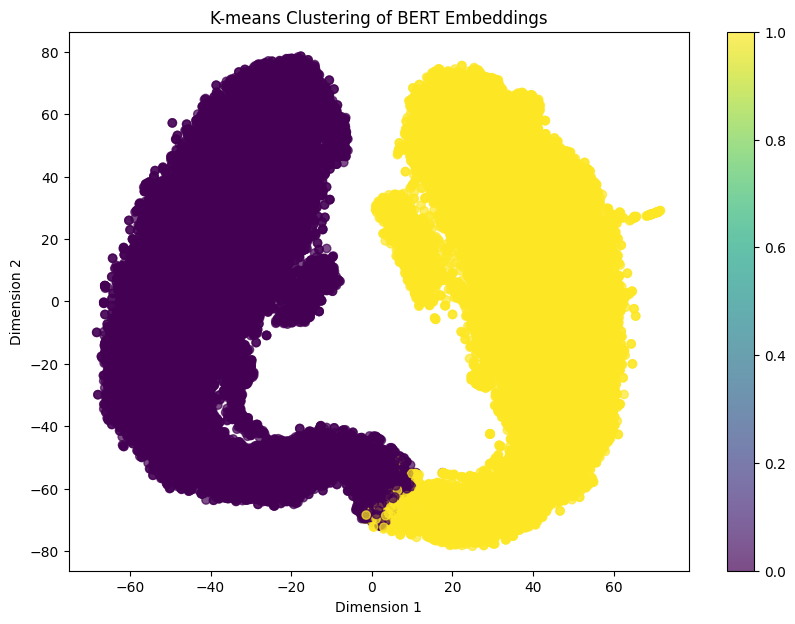

In [40]:
import matplotlib.pyplot as plt

# displaying the scatter plot of the reduced embeddings
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    reduced_embeddings[:, 0],  # X-axis
    reduced_embeddings[:, 1],  # Y-axis
    c=cluster_labels,          
    cmap='viridis',            
    alpha=0.7                  
)

plt.colorbar(scatter)
plt.title('K-means Clustering of BERT Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
# try to see what kinda of reviews are in each cluster
data = pd.DataFrame({
    'cluster': cluster_labels,
    'label': all_labels
})

# group by cluster and count labels
counts = data.groupby(['cluster', 'label']).size().unstack(fill_value=0)

print("Counts of labels in each cluster:")
print(counts)


Counts of labels in each cluster:
label        0      1
cluster              
0        24041   1456
1          959  23544


In [ ]:
from collections import defaultdict

texts = X_train + X_test + X_val

# group texts by their cluster label
cluster_texts = defaultdict(list)
for text, cluster in zip(texts, cluster_labels):
    cluster_texts[cluster].append(text)

cluster_combined_texts = {cluster: " ".join(text_list) for cluster, text_list in cluster_texts.items()}

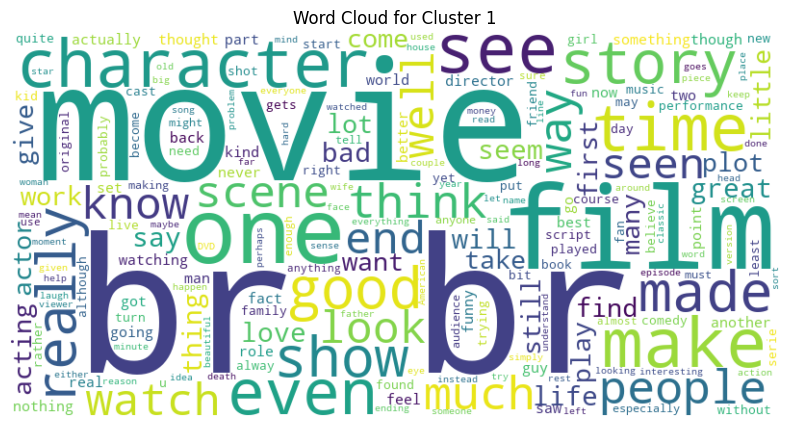

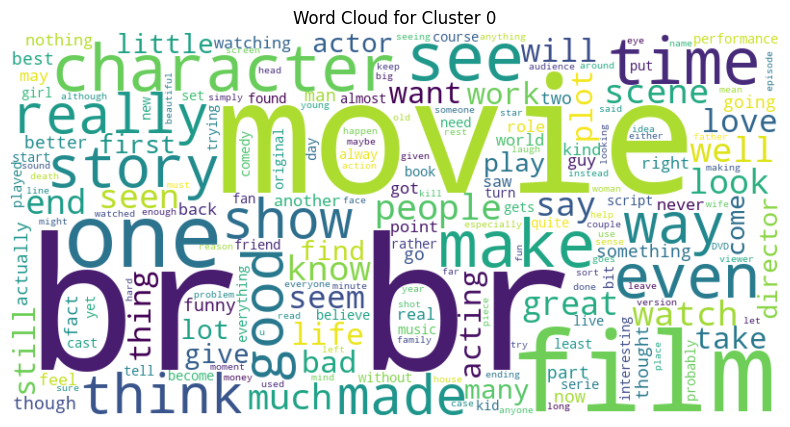

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cluster, text in cluster_combined_texts.items():
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white'
    ).generate(text)
    
    # plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster}")
    plt.show()